In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FormatStrFormatter

from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
folder_path = "data"
# folder_path = "data_small"

In [3]:
def unarchive_and_read_tsv(prefix, tsv_filename):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    tsv_file = os.path.join(unarchived_folder, tsv_filename)
    dataframe = pd.read_csv(tsv_file, delimiter='\t')
    return dataframe


In [4]:
prefix = "clinical"
tsv_filename = "clinical.tsv"

clinical_df = unarchive_and_read_tsv(prefix, tsv_filename)
print(clinical_df)

File already unarchived.
                                   case_id case_submitter_id project_id   
0     001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG  \
1     001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG   
2     0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
3     0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
4     0073a136-d5f4-4fd6-88f9-711768f2abc6      TCGA-VM-A8CF   TCGA-LGG   
...                                    ...               ...        ...   
1726  fee2114e-f723-4374-91f8-f1dcc6b3eaee      TCGA-HT-7470   TCGA-LGG   
1727  ffcec8e5-9fd3-4b42-a7cb-74761f713cf4      TCGA-HT-7606   TCGA-LGG   
1728  ffcec8e5-9fd3-4b42-a7cb-74761f713cf4      TCGA-HT-7606   TCGA-LGG   
1729  fff304a2-113f-499d-a88c-9d3660c348d9      TCGA-RY-A847   TCGA-LGG   
1730  fff304a2-113f-499d-a88c-9d3660c348d9      TCGA-RY-A847   TCGA-LGG   

     age_at_index age_is_obfuscated cause_of_death cause_of_death_source  

In [5]:
# Remove duplicate rows based on 'case_submitter_id' column
print(f'Shape before deduplication: {clinical_df.shape}')
clinical_df = clinical_df.drop_duplicates(subset='case_submitter_id', keep='first')
print(f'Shape after deduplication: {clinical_df.shape}')

print(clinical_df.head())

Shape before deduplication: (1731, 158)
Shape after deduplication: (822, 158)
                                case_id case_submitter_id project_id   
0  001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG  \
2  0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
4  0073a136-d5f4-4fd6-88f9-711768f2abc6      TCGA-VM-A8CF   TCGA-LGG   
6  0078b0c4-68a9-483b-9aab-61156d263213      TCGA-14-1034   TCGA-GBM   
8  00b18ad6-ff70-41fe-8f4d-0763ac8f28b9      TCGA-HT-7677   TCGA-LGG   

  age_at_index age_is_obfuscated cause_of_death cause_of_death_source   
0           47               '--            '--                   '--  \
2           31               '--            '--                   '--   
4           44               '--            '--                   '--   
6           60               '--            '--                   '--   
8           53               '--            '--                   '--   

  country_of_residence_at_enrollment days_to_birth

In [6]:

clinical_df.set_index('case_submitter_id', inplace=True)
print(clinical_df.head())

                                                case_id project_id   
case_submitter_id                                                    
TCGA-HT-A614       001ad307-4ad3-4f1d-b2fc-efc032871c7e   TCGA-LGG  \
TCGA-E1-5311       0061e9ef-df6a-414e-af64-c88f8192e2d3   TCGA-LGG   
TCGA-VM-A8CF       0073a136-d5f4-4fd6-88f9-711768f2abc6   TCGA-LGG   
TCGA-14-1034       0078b0c4-68a9-483b-9aab-61156d263213   TCGA-GBM   
TCGA-HT-7677       00b18ad6-ff70-41fe-8f4d-0763ac8f28b9   TCGA-LGG   

                  age_at_index age_is_obfuscated cause_of_death   
case_submitter_id                                                 
TCGA-HT-A614                47               '--            '--  \
TCGA-E1-5311                31               '--            '--   
TCGA-VM-A8CF                44               '--            '--   
TCGA-14-1034                60               '--            '--   
TCGA-HT-7677                53               '--            '--   

                  cause_of_death_source

In [7]:
tsv_filename = "gdc_sample_sheet.2023-06-15.tsv"

sample_sheet = pd.read_csv(os.path.join(folder_path, tsv_filename), delimiter='\t')
sample_sheet.set_index('Case ID', inplace=True)

clinical_df_joined = clinical_df.join(sample_sheet, how='inner')
clinical_df_joined.set_index('case_id', inplace=True)
clinical_df_joined

,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,ethnicity,gender,...,treatment_or_therapy,treatment_outcome,treatment_type,File ID,File Name,Data Category,Data Type,Project ID,Sample ID,Sample Type
case_id,,,,,,,,,,,,,,,,,,,,,
d42636dd-728c-45a4-b953-db165a30c761,CPTAC-3,'--,'--,Unknown,'--,'--,-21197,129,not hispanic or latino,male,...,'--,'--,'--,73d57ab1-1757-4af3-b229-90050dcdb9e0,1fbd55b4-c08b-44b8-940e-6538cc79ef68.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00104-01,Primary Tumor
0c38f553-6892-4f67-b306-40503b8842b5,CPTAC-3,'--,'--,Unknown,'--,'--,-21654,322,not hispanic or latino,female,...,'--,'--,'--,0997ec63-6fe0-40fb-b0ff-3ddcb14ec7d2,b7effa07-1b05-412a-a1ef-54d52d795c90.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00365-01,Primary Tumor
e1bd6dfa-0567-46e7-991c-63eefaf5bd7a,CPTAC-3,'--,'--,Cancer Related,'--,'--,-16667,478,not hispanic or latino,male,...,'--,'--,'--,5fbd8f83-c1ce-4ff5-9c98-c74eb6412484,166baf7b-6f56-4108-b9b2-191a623f6092.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00674-71,Primary Tumor
f5287051-d58d-4243-8a07-5fdfb5afa301,CPTAC-3,'--,'--,Cancer Related,'--,'--,-25562,155,not hispanic or latino,female,...,'--,'--,'--,699eceef-c640-4740-afb9-5e4952979493,b2d1e197-8003-4751-8d87-448fbdd1c597.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00677-72,Primary Tumor
206f20bb-c212-4a26-967a-5b3700f322be,CPTAC-3,'--,'--,Cancer Related,'--,'--,-21551,79,not reported,male,...,'--,'--,'--,9dc20a35-75a6-4eea-9b53-ac47d2e1101f,c25a3ea3-a975-441e-a9ac-d4f3d970d914.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-01043-01,Primary Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09552b53-4393-4811-a671-a9ef6eff4790,TCGA-LGG,20,'--,'--,'--,'--,-7380,'--,not reported,male,...,no,'--,"Pharmaceutical Therapy, NOS",3efa8a3e-17f2-43ea-9e5e-cfe0623b350c,18869398-2fb5-40b2-b7a9-a2f76d5e0593.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85A-01A,Primary Tumor
cb041720-0efa-4eb6-a9a5-b6e138bb1a99,TCGA-LGG,24,'--,'--,'--,'--,-8817,'--,not reported,male,...,no,'--,"Radiation Therapy, NOS",d2435a77-2eb7-4de5-8e6a-44521a71b0cf,03c821eb-9f43-4966-95b7-bad7d2985dac.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85B-01A,Primary Tumor
f62be2b8-88c4-4a7e-8c80-8176fb5f6c56,TCGA-LGG,36,'--,'--,'--,'--,-13506,'--,not reported,male,...,yes,'--,"Pharmaceutical Therapy, NOS",9908b233-1fd5-4c57-8164-22c195dd8752,e870cd62-cce9-4376-b362-8c2a6911c3e3.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85C-01A,Primary Tumor


In [8]:
def parse_tsv_file(file_path):
    dataframe = pd.read_csv(file_path, delimiter='\t', comment='#')
    dataframe = dataframe[dataframe['gene_id'].str.startswith('ENSG')]
    dataframe = dataframe[['gene_id', 'tpm_unstranded']]
    dataframe = dataframe.set_index('gene_id').T
    return dataframe

In [9]:
def unarchive_and_build_dataframe(folder_path, prefix):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    dataframes = []
    for folder_name in os.listdir(unarchived_folder):
        folder_path = os.path.join(unarchived_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
        if len(tsv_files) == 1:
            tsv_file = os.path.join(folder_path, tsv_files[0])
            dataframe = parse_tsv_file(tsv_file)
            dataframe.insert(0, 'file_id', [folder_name])
            dataframes.append(dataframe)

    if not dataframes:
        print("No .tsv files found.")
        return None

    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    combined_dataframe.set_index('file_id', inplace=True)
    return combined_dataframe


In [10]:
prefix = "gdc_download"
data = None
data = unarchive_and_build_dataframe(folder_path, prefix)
# remove the first column
# data = data.iloc[:, 1:]
print(data)

File already unarchived.


gene_id                               ENSG00000000003.15  ENSG00000000005.6   
file_id                                                                       
3dcabc66-481a-4709-ae10-aeff98ffa879             35.6027             0.0250  \
4b5a3053-b06d-4b3a-9460-54bd39453502             48.8689             1.4692   
e9be8247-b6e1-486a-afcd-e33e71684229             18.8551             0.1948   
d533e7df-d05e-4501-848b-ebde39845cb9             23.7059             0.4353   
d20cf786-ccae-4aba-a46b-06355adf7e0a             40.0514             0.1564   
...                                                  ...                ...   
b1c41433-20be-49d8-b3d2-87dc7beeb3a8             45.1670             0.2646   
0d551c2a-a684-4b1e-bc8e-a30b0ee01cd7             27.3548             0.3700   
640a5b45-8d37-48c4-8d78-90e848071d50             43.3470             0.7489   
a592fdde-b880-4901-9a35-cbea7326e2dd             37.4561             0.0000   
3efa8a3e-17f2-43ea-9e5e-cfe0623b350c             39.

In [11]:
print(data.shape)
print(clinical_df_joined.shape)

# merge the two dataframes
data = data.loc[clinical_df_joined["File ID"]]

print(data.shape)
print(clinical_df_joined.shape)

(885, 60660)
(859, 163)
(859, 60660)
(859, 163)


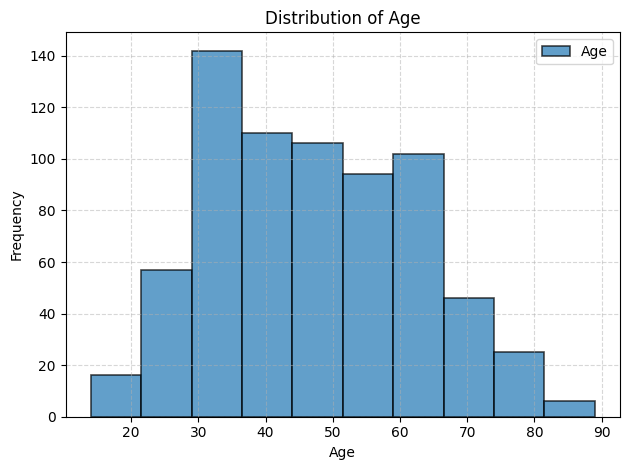

In [12]:
# some age values are missing (they are '--)
# we will drop them
float_idx = clinical_df_joined['age_at_index'].map(lambda x: x.isdigit()).values
age = clinical_df_joined.loc[float_idx, 'age_at_index'].astype(float)
data_valid_age = data.loc[float_idx, :]

# Create the plot
plt.hist(age, bins=10, edgecolor='black', linewidth=1.2, alpha=0.7, label='Age')

# Set plot aesthetics
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing for x-axis tick labels
plt.tight_layout()

# Show the plot
plt.show()

# t-SNE

In [26]:
# Perform t-SNE analysis
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(data_valid_age)

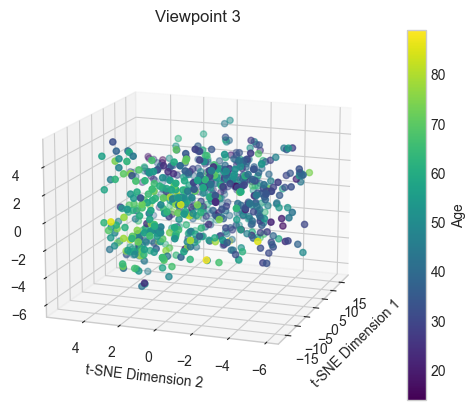

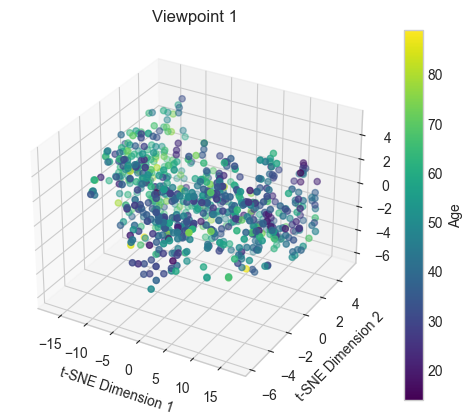

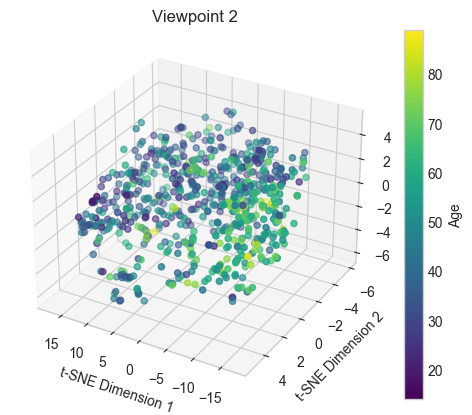

In [36]:
# Figure 1
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
scatter3 = ax3.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=age, cmap="viridis")
ax3.view_init(elev=15, azim=200)  # Adjust the elevation and azimuth angles
ax3.set_xlabel("t-SNE Dimension 1")
ax3.set_ylabel("t-SNE Dimension 2")
ax3.set_zlabel("t-SNE Dimension 3")
ax3.set_title("Viewpoint 3")
plt.colorbar(scatter3, ax=ax3, label="Age")

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
scatter1 = ax1.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=age, cmap="viridis")
ax1.set_xlabel("t-SNE Dimension 1")
ax1.set_ylabel("t-SNE Dimension 2")
ax1.set_zlabel("t-SNE Dimension 3")
ax1.set_title("Viewpoint 1")
plt.colorbar(scatter1, ax=ax1, label="Age")

# Figure 3
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
scatter2 = ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=age, cmap="viridis")
ax2.view_init(elev=30, azim=120)  # Adjust the elevation and azimuth angles
ax2.set_xlabel("t-SNE Dimension 1")
ax2.set_ylabel("t-SNE Dimension 2")
ax2.set_zlabel("t-SNE Dimension 3")
ax2.set_title("Viewpoint 2")
plt.colorbar(scatter2, ax=ax2, label="Age")


plt.show()

In [13]:
# random drop data augmentation
# we will drop 10% of the data
# this is to prevent overfitting
# and to make the model more robust
data_valid_age_aug = data_valid_age.copy()
mask = pd.DataFrame(np.random.rand(*data_valid_age_aug.shape)) < 0.1
data_valid_age_aug[mask] = 0

final_data = pd.concat([data_valid_age_aug, data_valid_age])
final_age = pd.concat([age, age])
print(final_data.shape)
print(data_valid_age.shape)

# final_data = data_valid_age
# final_age = age

(1408, 60660)
(704, 60660)


In [14]:
# K = 400

# # perform feature selection
# test = SelectKBest(score_func=f_regression, k=K)
# features = test.fit_transform(final_data, final_age)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(final_data, final_age, test_size=0.2, random_state=42)

# Train an XGBoost regression model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 12.522685251471636


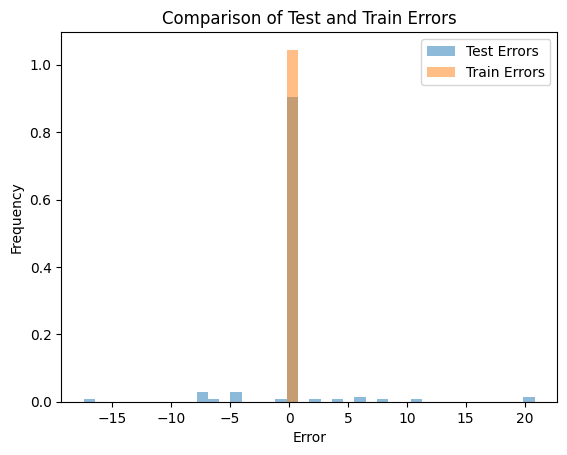

In [15]:
predictions = model.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
errors = results['Actual'] - results['Predicted']

predictions_train = model.predict(X_train)
results_train = pd.DataFrame({'Actual': y_train, 'Predicted': predictions_train})
errors_train = results_train['Actual'] - results_train['Predicted']

# Determine the common range for both histograms
min_error = min(errors.min(), errors_train.min())
max_error = max(errors.max(), errors_train.max())

# Plot the histograms
plt.hist(errors, bins=40, alpha=0.5, range=(min_error, max_error), label='Test Errors', density=True)
plt.hist(errors_train, bins=40, alpha=0.5, range=(min_error, max_error), label='Train Errors', density=True)

# Add labels and title
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Comparison of Test and Train Errors')

# Add legend
plt.legend()

# Show the plot
plt.show()

/var/folders/lx/hcq41t1d6sq3sc8fcv87wqzm0000gn/T/ipykernel_49635/2317227693.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


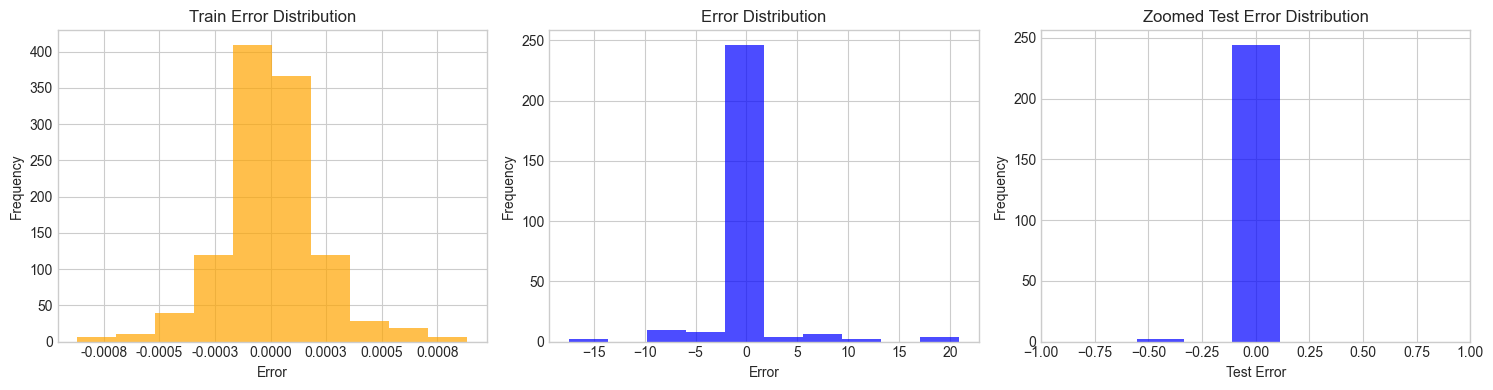

In [16]:
# Set style
plt.style.use('seaborn-whitegrid')

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot distribution of train errors
axes[0].hist(errors_train, color='orange', alpha=0.7)
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Train Error Distribution')

# Plot distribution of errors
axes[1].hist(errors, color='blue', alpha=0.7)
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')

# Calculate the distribution of errors within the range from -1 to 1
target_range = (-1, 1)
errors_zoomed = [error for error in errors if target_range[0] <= error <= target_range[1]]
bins_zoomed = np.linspace(target_range[0], target_range[1], num=10)  # Adjust the number of bins as desired

# Plot zoomed-in distribution of errors in the range from -1 to 1
axes[2].hist(errors_zoomed, bins=bins_zoomed, color='blue', alpha=0.7)
axes[2].set_xlabel('Test Error')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Zoomed Test Error Distribution')
axes[2].set_xlim(target_range)

# Format x-axis labels to 2 decimal places
# for ax in axes:
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

# Adjust spacing and layout
plt.subplots_adjust(wspace=0.4)
fig.tight_layout()

# Show the plot
plt.show()

In [18]:
results.values

array([[71.        , 70.99993134],
       [63.        , 62.99951553],
       [62.        , 61.9996376 ],
       [36.        , 35.99967575],
       [46.        , 53.66043091],
       [35.        , 34.99976349],
       [31.        , 31.00022697],
       [45.        , 44.99992752],
       [39.        , 38.99958038],
       [53.        , 53.00016403],
       [43.        , 42.99944687],
       [51.        , 39.73839188],
       [32.        , 32.00019836],
       [36.        , 36.00046539],
       [44.        , 43.99944687],
       [72.        , 71.99952698],
       [43.        , 47.16193008],
       [64.        , 63.99940491],
       [26.        , 26.00016785],
       [50.        , 49.99959183],
       [29.        , 29.00069618],
       [74.        , 73.99967194],
       [21.        , 21.00028992],
       [45.        , 45.00009918],
       [34.        , 41.65962601],
       [58.        , 58.00031662],
       [44.        , 43.99987793],
       [40.        , 39.99977875],
       [57.        ,